<a href="https://colab.research.google.com/github/asmaakhaledd/PID-NN/blob/optimized-PID-Model/Inference_of_Opt_PID.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install numpy pandas tensorflow

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
import random

Load model

In [4]:
# Load the trained model
def load_model(model_path):
    pid_model = tf.keras.models.load_model(model_path, compile=False)
    pid_model.compile(optimizer='adam', loss=tf.keras.losses.MeanSquaredError())
    return pid_model

Preprocess time features (cyclic encoding)

In [5]:
# Preprocess time features (Use timestep as timestamp)
def preprocess_time_features(timestep, glucose, weight):
    # Using cyclic encoding for time, but we will use timestep as time (1, 2, 3,...)
    hour = timestep % 24
    minute = 0  # Simulate with minute 0 for simplicity
    time_sin = np.sin(2 * np.pi * hour / 24)
    time_cos = np.cos(2 * np.pi * hour / 24)
    return [glucose - 110, glucose - random.uniform(70, 180), weight, time_sin, time_cos]

Prepare PID data for inference

In [6]:
# Prepare PID data for inference
def prepare_pid_data(timestep, glucose, weight):
    # Preprocess real-time data for the PID model
    return np.array([preprocess_time_features(timestep, glucose, weight)])

Adjust basal insulin dosage based on glucose and weight

In [49]:
def adjust_basal_insulin(glucose_level, weight, Kp, Ki, Kd, previous_glucose, cumulative_error):
    # Basal insulin rate calculation based on weight
    basal_rate_per_kg = 0.5
    TDI = basal_rate_per_kg * weight  # Total daily insulin
    basal_insulin_dosage = 0.5 * TDI  # Basal insulin dosage (50% of TDI)
    hourly_basal_rate = basal_insulin_dosage / 24  # Hourly basal rate

    # Target glucose level
    target_glucose = 110

    # Calculate the error (difference between current glucose and target)
    error = glucose_level - target_glucose

    # Proportional (Kp) term: Respond to immediate error
    adjustment_factor_proportional = Kp * error

    # Integral (Ki) term: Cumulative error over time
    cumulative_error += error  # Update cumulative error
    adjustment_factor_integral = Ki * cumulative_error

    # Derivative (Kd) term: Rate of change in glucose
    glucose_change_rate = glucose_level - previous_glucose  # Difference between current and previous glucose levels
    adjustment_factor_derivative = Kd * glucose_change_rate

    # Total adjusted basal rate including all PID terms
    adjusted_basal_rate = hourly_basal_rate + adjustment_factor_proportional + adjustment_factor_integral + adjustment_factor_derivative

    # Apply limits to the basal rate to prevent it from becoming too low or too high
    min_basal_rate = 0.3
    max_basal_rate = 1.5
    adjusted_basal_rate = max(min_basal_rate, min(adjusted_basal_rate, max_basal_rate))


    # Return the adjusted basal rate and the updated cumulative error for next use
    return adjusted_basal_rate, cumulative_error, glucose_level

Bolus Calculation

In [81]:
def calculate_bolus(weight, glucose_level, target_glucose, meal_carbs, insulin_type='rapid'):
    # Calculate Total Daily Insulin (TDI)
    TDI = weight * 0.55  # For weight in kg

    # Calculate Basal and Bolus
    basal_insulin = 0.4 * TDI
    bolus_insulin = 0.6 * TDI

    # Calculate the Correction Factor based on insulin type
    if insulin_type == 'rapid':
        correction_factor = 1500 / TDI
    elif insulin_type == 'regular':
        correction_factor = 1800 / TDI

    # Calculate correction dose if BG is above target
    correction_dose = 0
    if glucose_level > target_glucose:
        correction_dose = (glucose_level - target_glucose) / correction_factor

    # Calculate carb-to-insulin ratio
    carb_to_insulin_ratio = 500 / TDI

    # Calculate bolus insulin based on carbs in the meal
    bolus_for_meal = meal_carbs / carb_to_insulin_ratio

    # Total bolus insulin for the meal including correction
    total_bolus = bolus_for_meal + correction_dose

    # Limit the bolus insulin to a safe range
    min_bolus = 0.5  # Minimum bolus insulin per meal
    max_bolus = 10.0  # Maximum bolus insulin per meal
    total_bolus = max(min_bolus, min(total_bolus, max_bolus))

    print(f"Bolus for meal: {bolus_for_meal:.2f} units, Correction dose: {correction_dose:.2f} units, Total bolus: {total_bolus:.2f} units")

    return total_bolus

Predict insulin dosage

In [78]:
def predict_insulin_dosage(pid_model, glucose, weight, timestep, previous_glucose, cumulative_error):
    # Prepare input data for PID model
    X_pid_test = prepare_pid_data(timestep, glucose, weight)

    # Make prediction using the trained PID model (predicting Kp, Ki, Kd)
    predicted_pid_gains = pid_model.predict(X_pid_test)

    # Extract predicted PID gains (Kp, Ki, Kd)
    Kp, Ki, Kd = predicted_pid_gains[0]

    # Adjust basal insulin based on the predicted PID gains and glucose level
    adjusted_basal_rate, cumulative_error, previous_glucose = adjust_basal_insulin(
        glucose, weight, Kp, Ki, Kd, previous_glucose, cumulative_error
    )

    # Print the result
    print(f"\nSample {timestep}:")
    print(f"Timestep: {timestep}")
    print(f"Glucose: {glucose:.2f} mg/dL")
    print(f"Adjusted Hourly Basal Insulin: {adjusted_basal_rate:.2f} U per hour")
    print(f"Weight: {weight} kg")
    print(f"previous glucose: {previous_glucose},cumulative error: {cumulative_error}")
    print(f"Ki: {Ki},Kp: {Kp},Kd: {Kd}")
    print("-" * 50)

    # Return updated values to be used in the next timestep
    return previous_glucose, cumulative_error, glucose, adjusted_basal_rate

Patient simulator

In [79]:
from collections import deque

class HovorkaPatientSimulator:
    def __init__(self):
        # Safer initial state
        init_glucose = np.random.uniform(100, 140)
        self.Q1 = init_glucose / 18
        self.Q2 = init_glucose / 18
        self.S1 = 0
        self.S2 = 0
        self.Ra = 0
        self.glucose_history = deque([init_glucose/400]*6, maxlen=6)

        # Insulin sensitivity with variability
        self.insulin_effect = 0
        self.insulin_effect_half_life = 90  # minutes

        # Model parameters with ±10% variability
        self.F01 = 0.0097 * np.random.uniform(0.9, 1.1)
        self.EGP0 = 0.0161 * np.random.uniform(0.9, 1.1)
        self.VG = 1.88 * np.random.uniform(0.95, 1.05)
        self.VI = 0.05 * np.random.uniform(0.9, 1.1)
        self.k12 = 0.066 * np.random.uniform(0.9, 1.1)
        self.ke = 0.138 * np.random.uniform(0.9, 1.1)
        self.ka1 = 0.006 * np.random.uniform(0.8, 1.2)
        self.ka2 = 0.06 * np.random.uniform(0.8, 1.2)
        self.ka3 = 0.03 * np.random.uniform(0.8, 1.2)
        self.SIT = 51.2e-4 * np.random.uniform(0.8, 1.2)
        self.SID = 8.2e-4 * np.random.uniform(0.8, 1.2)
        self.SIE = 520e-4 * np.random.uniform(0.8, 1.2)

        # Meal tracking
        self.active_meals = []
        self.time_since_last_meal = 360

    def update(self, insulin_rate, time_step=1):
        # Hard safety limit
        insulin_rate = np.clip(insulin_rate, 0, 0.2)

        # Emergency glucose correction
        if self.Q1 * 18 < 60:
            self.Q1 = 110 / 18
            self.Q2 = 110 / 18
            return 110

        # Update insulin effect
        self.insulin_effect *= 0.5**(time_step/self.insulin_effect_half_life)
        self.insulin_effect += insulin_rate * time_step

        # Dynamic sensitivity
        sensitivity_factor = 1 / (1 + 0.01 * self.insulin_effect)

        insulin_input = insulin_rate / self.VI

        # Update insulin compartments
        dS1 = insulin_input - self.ka1 * self.S1
        dS2 = self.ka1 * self.S1 - self.ke * self.S2
        self.S1 = np.clip(self.S1 + dS1 * time_step, 0, 1000)
        self.S2 = np.clip(self.S2 + dS2 * time_step, 0, 1000)

        # Update meal absorption
        self.Ra = 0
        remaining_meals = []

        for amount, time_passed in self.active_meals:
            time_passed += time_step
            if time_passed < 360:  # 6-hour absorption
                # Dual-phase absorption
                phase1 = 0.6 * amount * np.exp(-0.03 * time_passed)
                phase2 = 0.4 * amount * np.exp(-0.01 * time_passed)
                self.Ra += (phase1 + phase2) / 180.16
                remaining_meals.append((amount, time_passed))

        self.active_meals = remaining_meals
        self.time_since_last_meal += time_step

        # Glucose fluxes
        EGP = max(self.EGP0 * (1 - self.SID * sensitivity_factor * self.S2), 0)
        U = max(self.F01 + (self.SIT * sensitivity_factor * self.S2) * self.Q1, 0)

        # Update glucose
        dQ1 = -(self.k12 + self.SIE * sensitivity_factor * self.S2) * self.Q1 + self.k12 * self.Q2 - U + EGP + self.Ra
        dQ2 = self.k12 * self.Q1 - self.k12 * self.Q2
        self.Q1 = np.clip(self.Q1 + dQ1 * time_step, 0, 1000/18)
        self.Q2 = np.clip(self.Q2 + dQ2 * time_step, 0, 1000/18)

        # Update history
        glucose = self.Q1 * 18
        self.glucose_history.append(glucose/400)
        return glucose

    def administer_meal(self, carbs):
        actual_carbs = np.clip(carbs, 0, 80)  # Max 80g carbs
        # Split into immediate and delayed components
        self.active_meals.append((actual_carbs * 0.7, 0))  # Fast carbs (70%)
        self.active_meals.append((actual_carbs * 0.3, 0))  # Slow carbs (30%)
        self.time_since_last_meal = 0

    def get_state(self):
        history = list(self.glucose_history)

        # Calculate trends
        trend_short = history[-1] - history[-2] if len(history) >= 2 else 0
        trend_medium = history[-1] - history[-4] if len(history) >= 4 else 0

        # Meal impact
        meal_impact = sum(amount * (1 - min(time_passed/360, 1))
                        for amount, time_passed in self.active_meals) / 80

        return np.concatenate([
            np.array([
                self.Q1 * 18 / 400,       # Current glucose
                self.S1 / 100,            # Insulin compartment 1
                self.S2 / 100,            # Insulin compartment 2
                min(meal_impact, 1),      # Meal impact
                trend_short,              # Short-term trend
                trend_medium,             # Medium-term trend
                self.time_since_last_meal < 360  # Recent meal flag
            ]),
            np.array(history[-4:])        # Last 4 glucose values
        ], dtype=np.float32)

Main

In [103]:
if __name__ == "__main__":
    # Path to your saved model
    model_path = '/content/drive/MyDrive/GP PID/opt_pid_tuning_model_2.h5'

    # Load the model
    pid_model = load_model(model_path)

    # Initialize variables
    previous_glucose = 110  # Assume initial glucose is at target
    cumulative_error = 0

    # Set weight constant (can be updated as needed)
    weight = 70  # Constant weight

    # Initialize timestep
    timestep = 1

    # Variables for bolus calculation
    meal_carbs = 0

    # # Loop to simulate real-time data
    # while True:
    #     # Get simulated real-time glucose data (replace with actual CGM data in real use)
    #     glucose = random.uniform(70, 180)  # Simulated glucose value between 70 and 180 mg/dL

    #     # Perform prediction and insulin adjustment
    #     previous_glucose, cumulative_error = predict_insulin_dosage(
    #         pid_model, glucose, weight, timestep, previous_glucose, cumulative_error
    #     )

    #     # Increment timestep for next reading
    #     timestep += 1

    #     # Limit the number of samples to avoid infinite loop for testing
    #     if timestep > 100:  # Example condition to stop after 100 iterations (remove for infinite loop)
    #         break




    # # Generate consecutive glucose levels for each timestep
    # glucose_levels = []
    # basal_rates = []

    # initial_glucose = 100  # Initial glucose level
    # glucose_levels = [initial_glucose]

    # for i in range(1, 500):
    #       glucose_change = random.uniform(-5, 10)  # Random fluctuation between -5 and +10 mg/dL
    #       new_glucose = glucose_levels[-1] + glucose_change
    #       new_glucose = max(70, min(120, new_glucose))  # Clamp between 70 and 120 mg/dL
    #       glucose_levels.append(new_glucose)

    # # Initialize variables for simulation
    # previous_glucose = 110  # Initial glucose level for PID controller
    # cumulative_error = 0
    # weight = 70  # Constant weight
    # timestep = 1

    # # Loop over the generated glucose levels to simulate real-time data
    # for timestep in range(1, 501):  # Running for 100 timesteps
    #     # Choose a new glucose value for each timestep (from the generated list)
    #     glucose = glucose_levels[timestep % 500]  # Loop through the  generated glucose values

    #     if timestep == 1 or timestep % 15 == 0:
    #         previous_glucose, cumulative_error, glucose, adjusted_basal_rate = predict_insulin_dosage(
    #             pid_model, glucose, weight, timestep, previous_glucose, cumulative_error
    #         )

    #         basal_rates.append(adjusted_basal_rate)

    #         if timestep % 10 == 0:
    #             print(f"Processed Timestep {timestep}: Glucose: {glucose:.2f}, Basal Rate: {adjusted_basal_rate:.2f}")
    #     else:
    #         basal_rates.append(basal_rates[-1] if basal_rates else 1.0)  # Use last basal rate or default


    #     # Optionally print the timestep and glucose level (optional for debugging)
    #     if timestep % 10 == 0:
    #         print(f"Processed Timestep {timestep}: Glucose: {glucose:.2f}, Basal Rate: {adjusted_basal_rate:.2f}")




    # glucose_levels = []
    # basal_rates = []

    # # Loop to simulate real-time data
    # for timestep in range(1, 101):  # Running for 100 timesteps
    #     glucose = random.uniform(70, 180)  # Simulated glucose value between 70 and 180 mg/dL
    #     if timestep % 15 == 0:
    #         previous_glucose, cumulative_error, glucose, adjusted_basal_rate = predict_insulin_dosage(
    #             pid_model, glucose, weight, timestep, previous_glucose, cumulative_error
    #         )

    #         glucose_levels.append(glucose)
    #         basal_rates.append(adjusted_basal_rate)

    #         if timestep % 10 == 0:
    #             print(f"Processed Timestep {timestep}: Glucose: {glucose:.2f}, Basal Rate: {adjusted_basal_rate:.2f}")
    #     else:
    #         # If it's not a multiple of 15, still append the glucose level but skip basal rate calculation
    #         glucose_levels.append(glucose)
    #         basal_rates.append(basal_rates[-1] if basal_rates else 1.0)  # Use last basal rate or default

    #     if timestep % 10 == 0:
    #         print(f"Processed Timestep {timestep}: Glucose: {glucose:.2f}, Basal Rate: {adjusted_basal_rate:.2f}")


  #  # Initialize glucose simulator
  #   patient_simulator = HovorkaPatientSimulator()

    # # Initialize glucose levels and basal rates lists
    # glucose_levels = []
    # basal_rates = []

    # # Loop over the generated glucose levels to simulate real-time data
    # for timestep in range(1, 301):  # Running for 500 timesteps
    #     # Simulate glucose update
    #     glucose = patient_simulator.update(insulin_rate=0)  # Insulin rate can be updated dynamically

    #     # Append the glucose level to the list for plotting
    #     glucose_levels.append(glucose)

    #     # Perform prediction and insulin adjustment every timestep
    #     if timestep == 1 or timestep % 15 == 0:
    #         previous_glucose, cumulative_error, glucose, adjusted_basal_rate = predict_insulin_dosage(
    #             pid_model, glucose, weight, timestep, previous_glucose, cumulative_error
    #         )

    #          # Feed the basal insulin rate back into the simulator
    #         glucose = patient_simulator.update(insulin_rate=adjusted_basal_rate)  # Update glucose with basal insulin

    #         basal_rates.append(adjusted_basal_rate)

    #         # Check for meal and calculate bolus (if a meal is administered)
    #         if meal_carbs > 0:  # If there is a meal
    #             total_bolus = calculate_bolus(weight, glucose, target_glucose=110, meal_carbs=meal_carbs)
    #             meal_carbs = 0  # Reset meal carbs after bolus calculation
    #         else:
    #             total_bolus = 0  # No bolus if no meal is administered

    #         if timestep % 10 == 0:
    #              print(f"Processed Timestep {timestep}: Glucose: {glucose:.2f}, Basal Rate: {adjusted_basal_rate:.2f}")

    #          # Simulate meal intake (just as an example)
    #         if timestep == 30:  # Example of a meal at timestep 50
    #             meal_carbs = 100  # Example of 50g carbs meal
    #         if timestep == 50:  # Example of a meal at timestep 50
    #             meal_carbs = 50  # Example of 50g carbs meal
    #     else:
    #         basal_rates.append(basal_rates[-1] if basal_rates else 1.0)  # Use last basal rate or default


    # Initialize glucose simulator
    patient_simulator = HovorkaPatientSimulator()

    # Initialize glucose levels, basal rates, and bolus insulin lists
    glucose_levels = []
    basal_rates = []
    bolus_insulin = []  # To store bolus insulin levels

    # Loop over the generated glucose levels to simulate real-time data
    for timestep in range(1, 301):  # Running for 300 timesteps
        # Simulate glucose update
        glucose = patient_simulator.update(insulin_rate=0)  # No insulin effect at this point

        # Perform prediction and insulin adjustment every timestep
        if timestep == 1 or timestep % 15 == 0:
            previous_glucose, cumulative_error, glucose, adjusted_basal_rate = predict_insulin_dosage(
                pid_model, glucose, weight, timestep, previous_glucose, cumulative_error
            )

            # Feed the basal insulin rate back into the simulator
            glucose = patient_simulator.update(insulin_rate=adjusted_basal_rate)  # Update glucose with basal insulin

            basal_rates.append(adjusted_basal_rate)
        else:
            # Fill missing basal rates with the last known value
            basal_rates.append(basal_rates[-1] if basal_rates else 1.0)  # Use last basal rate or default

        # Check for meal and calculate bolus (if a meal is administered)
        if meal_carbs > 0:  # If there is a meal
            total_bolus = calculate_bolus(weight, glucose, target_glucose=110, meal_carbs=meal_carbs)
            glucose += total_bolus * 20  # Adjust glucose based on the bolus (example conversion factor)
            bolus_insulin.append(total_bolus)  # Append bolus insulin value
            meal_carbs = 0  # Reset meal carbs after bolus calculation
        else:
            total_bolus = 0  # No bolus if no meal is administered
            bolus_insulin.append(0)  # Append 0 if no bolus

        # Simulate meal intake (just as an example, change meal size over time)
        if timestep == 30:  # Example of a meal at timestep 30
            meal_carbs = 100  # Example of 100g carbs meal
        if timestep == 200:  # Example of a meal at timestep 50
            meal_carbs = 50  # Example of 50g carbs meal

        # Append glucose level for plotting
        glucose_levels.append(glucose)

        # Optionally print the timestep and glucose level (optional for debugging)
        if timestep % 10 == 0:
            print(f"Processed Timestep {timestep}: Glucose: {glucose:.2f}, Basal Rate: {adjusted_basal_rate:.2f}, Bolus: {total_bolus:.2f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step

Sample 1:
Timestep: 1
Glucose: 124.19 mg/dL
Adjusted Hourly Basal Insulin: 1.50 U per hour
Weight: 70 kg
previous glucose: 124.18782922776562,cumulative error: 14.187829227765619
Ki: 0.013791872188448906,Kp: 0.13324180245399475,Kd: 0.00771802943199873
--------------------------------------------------
Processed Timestep 10: Glucose: 121.09, Basal Rate: 1.50, Bolus: 0.00
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step

Sample 15:
Timestep: 15
Glucose: 118.57 mg/dL
Adjusted Hourly Basal Insulin: 1.50 U per hour
Weight: 70 kg
previous glucose: 118.56907839050737,cumulative error: 22.75690761827299
Ki: 0.010833075270056725,Kp: 0.10873691737651825,Kd: 0.00654688011854887
--------------------------------------------------
Processed Timestep 20: Glucose: 114.24, Basal Rate: 1.50, Bolus: 0.00
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step

Sample 30:
Timestep: 30
Glucose: 105.47 mg/dL
Adjusted Hourly Basal Insulin: 0.46 U per hour
Weight: 70 kg
previous glucose: 105.474561

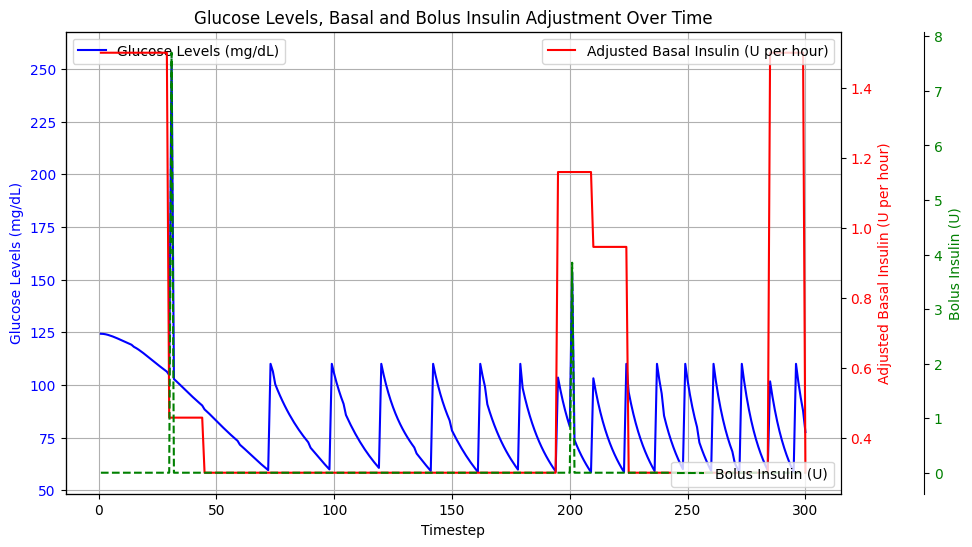

In [104]:
# Plotting glucose levels, basal rates, and bolus insulin levels
import matplotlib.pyplot as plt

# Create the figure and axis
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot glucose levels on the left y-axis
ax1.plot(range(1, 301), glucose_levels, label="Glucose Levels (mg/dL)", color='blue')
ax1.set_xlabel("Timestep")
ax1.set_ylabel("Glucose Levels (mg/dL)", color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.grid(True)

# Create a secondary y-axis for basal insulin rate
ax2 = ax1.twinx()  # This creates a second y-axis sharing the same x-axis
ax2.plot(range(1, 301), basal_rates, label="Adjusted Basal Insulin (U per hour)", color='red')
ax2.set_ylabel("Adjusted Basal Insulin (U per hour)", color='red')
ax2.tick_params(axis='y', labelcolor='red')

# Create a third y-axis for bolus insulin (optional, using ax1 or ax2 with different styling)
ax3 = ax1.twinx()  # Create a third y-axis
ax3.spines['right'].set_position(('outward', 60))  # Move the third y-axis outward for clarity
ax3.plot(range(1, 301), bolus_insulin, label="Bolus Insulin (U)", color='green', linestyle='--')
ax3.set_ylabel("Bolus Insulin (U)", color='green')
ax3.tick_params(axis='y', labelcolor='green')

# Title and legend
plt.title("Glucose Levels, Basal and Bolus Insulin Adjustment Over Time")
ax1.legend(loc="upper left")
ax2.legend(loc="upper right")
ax3.legend(loc="lower right")

# Show the plot
plt.show()